# **Fourier 2D**

<div style="color:#777777;margin-top: -15px;">
<b>Author</b>: Norman Juchler |
<b>Course</b>: ADLS ISP |
<b>Version</b>: v1.1 <br><br>
<!-- Date: 03.04.2025 -->
<!-- Comments: NOT refactored!!! -->
</div>

Fourier transforms in 2D are natural extensions of the 1D case. The 2D Fourier transform of a function $f(x, y)$ is defined as 
$$F(u, v) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x, y) e^{-2\pi i (ux + vy)} dx dy$$
where $u$ and $v$ are the spatial frequencies in the $x$ and $y$ directions, respectively. Instead of a single frequency, the 2D Fourier transform $F(u,v)$ represents a 2D spectrum of frequencies. This is the main difference between 1D and 2D Fourier transforms. The inverse 2D Fourier transform is given by
$$f(x, y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(u, v) e^{2\pi i (ux + vy)} du dv$$
All of the properties of the 1D Fourier transform that we discussed in the previous weeks also apply to the 2D Fourier transform. For example, the 2D Fourier transform of a convolution is the product of the Fourier transforms of the two functions:
$$\mathcal{F}(f * g) = \mathcal{F}(f)\cdot \mathcal{F}(g)$$

As in the 1D case, we can use the Fast Fourier Transform (FFT) to compute the 2D Fourier transform. The 2D FFT is implemented in the `numpy.fft` module. The relevant functions are `fft2` and `ifft2`.

In this exercise, we are going to explore what spectral images look like, and how we can interpret them.

---

## **Preparations**

The usual preparations... Before we begin, let's load some drawing functions for rendering images effortlessly in this Jupyter notebook.

In [1]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Functionality related to this course
sys.path.append("..")
import isp

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

---

<a id='exercise1'></a>

## **☆ Exercise 1: Sinusoidal gratings**

A sinusoidal grating is a sinusoidal pattern in which the amplitude of the sinusoid varies sinusoidally across the image. This is a common pattern in many natural scenes, and is often used in vision research to study the response of the visual system to different spatial frequencies. Here, we will use a sinusoidal grating to illustrate the Fourier transform of an image.

Mathematically, a sinusoidal grating with spatial frequency $f$ or wavelength $\lambda = 1/f$ is defined as:
$$g(x, y) = A \cdot sin\left(2 \pi f x + \varphi\right) = A \cdot sin\left(\frac{2 \pi x}{\lambda} + \varphi\right) $$

To generate a sinusoidal grating, we can use the following code:

In [2]:
def sinusoidal_grating(shape, A=1., l=10, phi=0, offset=0):
    """Generate a sinusoidal grating image (dtype: float32).
    (OpenCV uses float32 or uint8 for images)
    """
    # Horizontal pixel positions
    i = np.arange(shape[0])
    # Vertical pixel positions
    j = np.arange(shape[1])
    # Generate a grid of pixel positions
    X, Y = np.meshgrid(i, j)
    # Generate the sinusoidal grating
    img = A * np.sin(2 * np.pi / l * X + phi) + offset
    return img.astype(np.float32)

The code makes use of [`np.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html). This function generates a grid of coordinates (X, Y) for the given pixel positions i and j. The function returns two arrays, X and Y, that contain the two pixel coordinates of each point in the grid. 

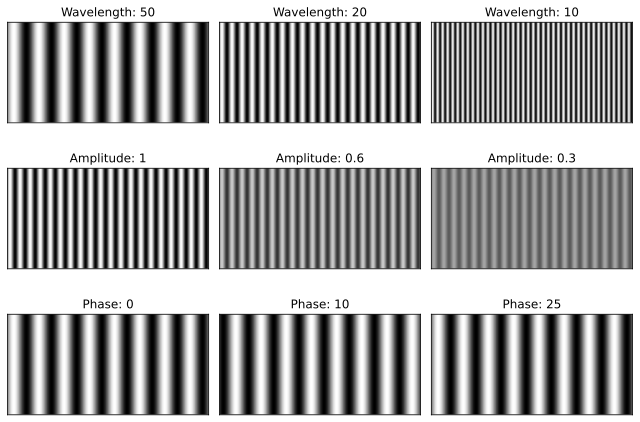

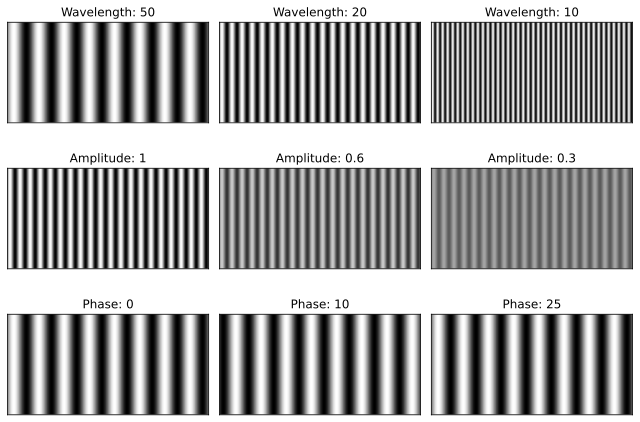

In [3]:
width = 400
height = 200
lambdas = [50, 20, 10]
amps = [1, 0.6, 0.3]
phases = [0, 10, 25]

imgs = {}
for l in lambdas:
    img = sinusoidal_grating((width, height), A=1, l=l, phi=0)
    imgs["Wavelength: {:.3g}".format(l)] = img
for A in amps:
    img = sinusoidal_grating((width, height), A=A, l=20, phi=0)
    imgs["Amplitude: {:.3g}".format(A)] = img
for phi in phases:
    img = sinusoidal_grating((width, height), A=1, l=50, phi=phi)
    imgs["Phase: {:.3g}".format(phi)] = img

isp.show_image_grid(images=imgs.values(), titles=imgs.keys(),  
                    ncols=3, normalize=[-1, 1], suppress_info=True)

#### **Instructions**
* Write a new function `sinusoidal_grating_dir()` that takes an additional argument `angle` that specifies the orientation of the grating.
* Hint: You may want to apply your understanding about affine transformations.
* Use your function to create a sinusoidal grating at an angle of 30°.

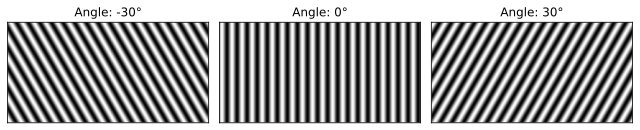

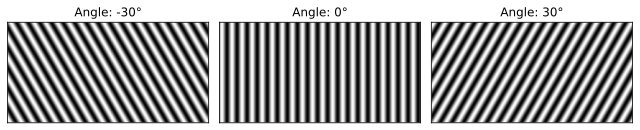

In [8]:
######################
###    EXERCISE    ###
######################


def sinusoidal_grating_dir(shape, A, l, phi=0, angle=0, offset=0):
    i = np.arange(shape[0])
    j = np.arange(shape[1])
    X, Y = np.meshgrid(i, j)
    angle = np.deg2rad(angle)
    img = A * np.sin(2 * np.pi / l * ((X*np.cos(angle) + Y*np.sin(angle))) + phi) + offset
    return img.astype(np.float32)

width = 400
height = 200
angles = [-30, 0,  30]
imgs = {}
for angle in angles:
    img = sinusoidal_grating_dir((width, height), A=1, l=20, phi=0, angle=angle)
    imgs["Angle: {:.3g}°".format(angle)] = img
isp.show_image_grid(images=imgs.values(), titles=imgs.keys(),  
                    ncols=5, normalize=[-1,1], suppress_info=True)

---

<a id='exercise2'></a>

## **☆ Exercise 2: 2D Fourier transform – Reading exercise**

[This tutorial](https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/) from The Python Coding Book nicely introduces the Fourier transform for images. 

Note that the tutorial (and this Jupyter notebook) operates with images represented by floating point numbers, contrary to the images we have seen so far with integral data types (e.g., `np.uint8`). This allows us to have images with negative values. 
 
Of course, we can also display floating point images. However, we need to specify how the values should be mapped to intensities. The `normalize` parameter that you will see here and there in the code snippets is used for this purpose. It sets the minimum and maximum values of the image to map to 0 and 255. See also the documentation of [`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) for more details.


### **Instructions**
* Read the article
* Answer in own words:
  1. What is the purpose of the Fourier transform?
  2. How are the above gratings involved in this?
  3. Which are the Python functions required to apply a Fourier transform?


Answer to Question 1:
The Fourier transform converts an image from the spatial domain to the frequency domain. It helps identify the different frequencies (patterns and textures) that make up an image, which is useful for filtering, compression, and analysis.

Answer to Question 2:
Gratings are simple wave-like patterns used to illustrate how different frequencies appear in the Fourier domain. Each grating corresponds to a single frequency, and their Fourier transforms show distinct points that represent the orientation and frequency of the pattern.

Answer to Question 3:
The main Python functions used for 2D Fourier transforms are:

np.fft.fft2() – computes the 2D Fourier transform

np.fft.fftshift() – moves the zero-frequency component to the center

np.abs() – computes the magnitude spectrum

plt.imshow() – displays the result with proper normalization

---

<a id='exercise3'></a>

## **☆ Exercise 3: 2D Fourier transform – Gratings**

In this exercise, we will generate sinusoidal gratings with different orientations and compute the corresponding Fourier spectra. We can observe that the orientation of the grating is reflected in the orientation of the spectral components.

### **Instructions**
* Create a square grating of size 250 using the function from the previous exercise. Use a wavelength of 43 pixels at an angle of +30°
* Compute the FFT using the scipy.fft
* Shift the image using `scipy.fft.fftshift()` (why again?)
* Compute the amplitude (use abs())
* Normalize the amplitude by the number of samples (use `img.size`)
* Visualize the amplitude spectrum of the image (to see the details better you can crop the image to show only the center part)


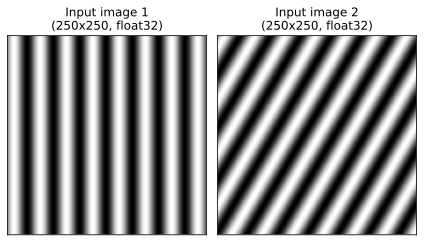

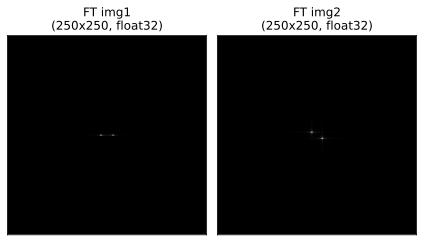

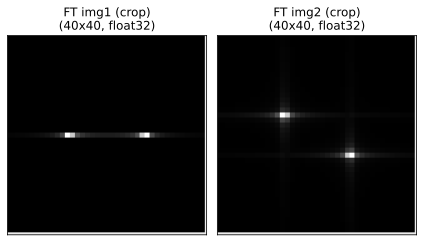

In [9]:
######################
###    EXERCISE    ###
######################
angle = 30
size = 250
angle = 30
wavelength = 33
amplitude = 1
phase = 0
s = 20  # Crop size

# Angle 0° (for comparison):
img1 = sinusoidal_grating_dir((size, size), A=amplitude, 
                              l=wavelength, phi=phase, 
                              angle=0)
# Discrete Fourier transform (FFT2) / amplitude spectrum
ft1 = scipy.fft.fft2(img1)
ft1 = scipy.fft.fftshift(ft1)
ft1 /= img1.size
ft1 = np.abs(ft1)
# Crop for detailed view
h,w = ft1.shape
ft1_crop = ft1[(h//2-s):(h//2+s), (w//2-s):(w//2+s)]


# Repeat for angle 30°
img2 = sinusoidal_grating_dir((size, size), A=amplitude, 
                              l=wavelength, phi=phase, 
                              angle=angle)
# Discrete Fourier transform (FFT2) / amplitude spectrum
ft2 = scipy.fft.fft2(img2)
ft2 = scipy.fft.fftshift(ft2)
ft2 = np.abs(ft2) / img2.size
# Crop for detailed view
h,w = ft2.shape
ft2_crop = ft2[(h//2-s):(h//2+s), (w//2-s):(w//2+s)]

isp.show_image_pair(img1, img2, 
                    title1="Input image 1", 
                    title2="Input image 2",
                    normalize=[-amplitude, amplitude]) 
isp.show_image_pair(ft1, ft2, 
                    title1="FT img1", 
                    title2="FT img2",
                    normalize=True) 
isp.show_image_pair(ft1_crop, ft2_crop, 
                    title1="FT img1 (crop)", 
                    title2="FT img2 (crop)",
                    normalize=True)

---

<a id='exercise4'></a>

## **☆ Exercise 4: 2D Fourier transform and filtering**

Let's now compute the amplitude spectrum for aribtrary images.

### **Instructions**
1. Use the image "../data/images/baboon.jpg"
2. Compute its FFT and the amplitude spectrum (use a logarithmic scale to see more)
3. Convolve the FFT of the image with a Gaussian kernel (see template)
4. Compute the inverse transform of the original FFT and the convolved FFT. Don't forget to use `ifftshift()` beforehand!
5. Visualize and describe your observations?

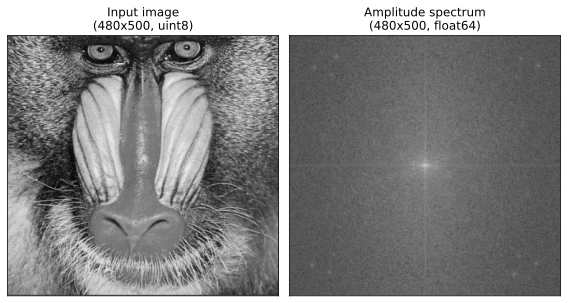

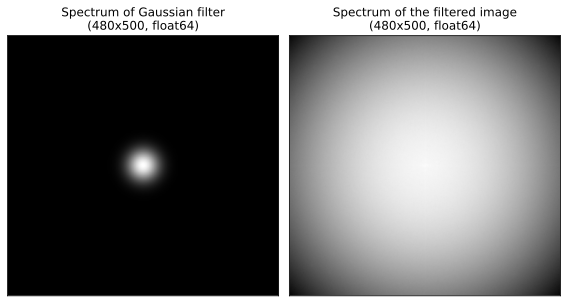

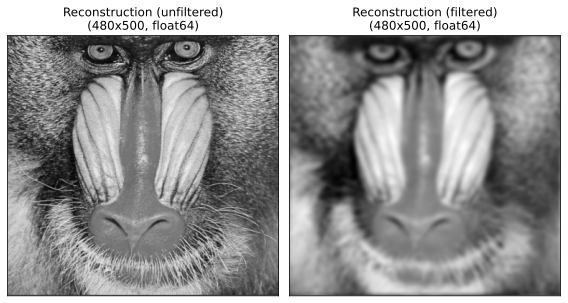

In [10]:
######################
###    EXERCISE    ###
######################
def gaussian_filter(shape, sigma):
    """Generate a Gaussian kernel.
    """
    x = np.linspace(-shape[1]//2, shape[1]//2, shape[1])
    y = np.linspace(-shape[0]//2, shape[0]//2, shape[0])
    X, Y = np.meshgrid(x, y)
    kernel = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

img = cv.imread("../data/images/baboon.jpg", cv.IMREAD_GRAYSCALE)
# img = scipy.fft.ifftshift(img)
ft = scipy.fft.fft2(img)
ft = scipy.fft.fftshift(ft)
ft_amp = np.abs(ft) / ft.size
ft_amp = np.log(ft_amp)
isp.show_image_pair(img, ft_amp, 
                    title1="Input image", 
                    title2="Amplitude spectrum", 
                    normalize=True, figsize=(8, 5))

ft_gaussian = gaussian_filter(img.shape, 20)
ft_filt = ft_gaussian * ft
ft_filt_amp = np.abs(ft_filt) / ft.size
ft_filt_amp = np.log(ft_filt_amp)
isp.show_image_pair(ft_gaussian, ft_filt_amp, 
                    title1="Spectrum of Gaussian filter", 
                    title2="Spectrum of the filtered image", 
                    normalize=True, figsize=(8, 5))

ft = scipy.fft.ifftshift(ft)
img_rec = scipy.fft.ifft2(ft)
img_rec = np.real(img_rec)

ft_filt = scipy.fft.ifftshift(ft_filt)
img_filt_rec = scipy.fft.ifft2(ft_filt)
img_filt_rec = np.real(img_filt_rec)

isp.show_image_pair(img_rec, img_filt_rec, 
                    title1="Reconstruction (unfiltered)", 
                    title2="Reconstruction (filtered)", 
                    normalize=True, figsize=(8, 5))
